## Compare Synthetic with Observations

per pixel error estimates


In [1]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
import sys
import folium
import xskillscore as xs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb

import contextily as ctx
from matplotlib.ticker import FormatStrFormatter

import odc.geo.xr
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [3]:
model_var='NDVI'
feat = 'CLIM'
base = '/g/data/os22/chad_tmp/AusENDVI/data/'

In [4]:
desert = xr.open_dataset(f'{base}synthetic/{model_var}/{model_var}_{feat}_desert_synthetic_5km_monthly_1982_2022.nc')[model_var]
nondesert = xr.open_dataset(f'{base}synthetic/{model_var}/{model_var}_{feat}_nondesert_synthetic_5km_monthly_1982_2022.nc')[model_var]
yy = xr.where(np.isnan(desert), nondesert, desert)

obs = xr.open_dataset(f'{base}{model_var}_harmonization/LGBM/{model_var}_{feat}_LGBM_5km_monthly_1982_2022_wGaps.nc')[model_var]

if model_var=='LST':
    yy = yy-273.15
    obs = obs-273.15

obs = obs.sel(time=yy.time)
gaps_mask = ~np.isnan(obs)
 
yy = yy.where(gaps_mask)

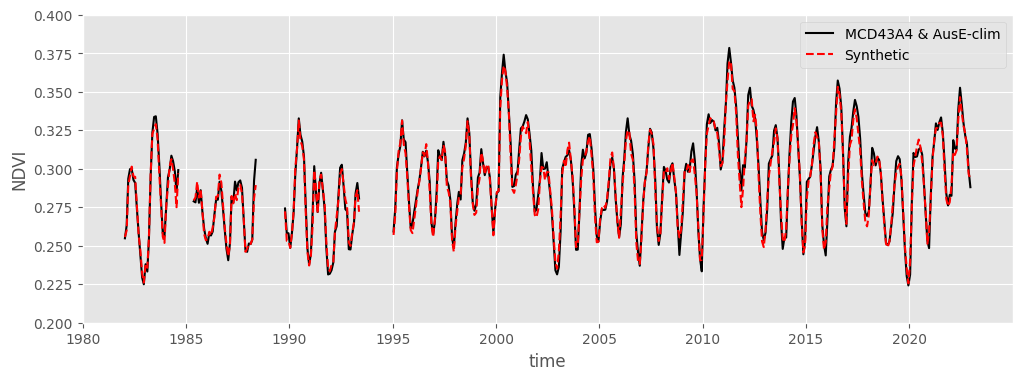

In [5]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    obs.mean(['latitude','longitude']).plot(ax=ax, label='MCD43A4 & AusE-clim', color='black')
    yy.mean(['latitude','longitude']).plot(ax=ax, label='Synthetic', color='red', linestyle='--')
    
    if model_var =='NDVI':
        ax.set_ylim(0.20, 0.40)
    if model_var =='LST':
        ax.set_ylim(25, 60)
    ax.legend()
    ax.set_title(None)

fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/syn_vs_obs_"+model_var+"_timeseries.png",
            bbox_inches='tight', dpi=300)
# plt.show()

### Error metrics

In [6]:
pred_mean = yy.mean('time')
obs_mean = obs.mean('time')
obs_mask = ~np.isnan(obs_mean)
low_ndvi_mask = xr.where(obs.mean('time')<0.125,0, 1)
pred_mean = pred_mean.where(obs_mask)
pred_mean = pred_mean.where(low_ndvi_mask)
obs_mean = obs_mean.where(low_ndvi_mask)

In [7]:
corr = xr.corr(obs, yy, dim='time').rename('Pearson Correlation')
corr = corr.where(low_ndvi_mask)
corr = corr.where(obs_mask)

rmse = xs.rmse(obs,yy, dim='time', skipna=True).rename('RMSE')
rmse = rmse.where(low_ndvi_mask)
rmse = rmse.where(obs_mask)

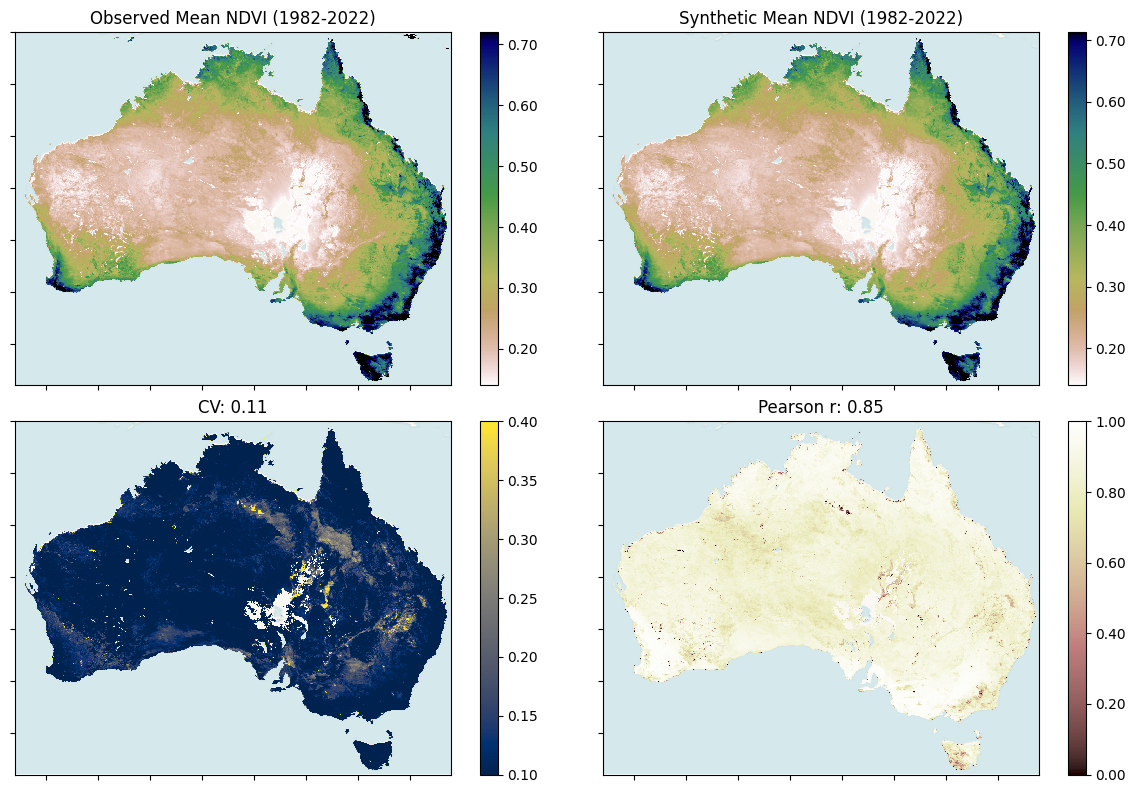

In [8]:
corr_data = [obs_mean, pred_mean, rmse/obs_mean, corr]

products=['Observed Mean '+model_var+' (1982-2022)', 'Synthetic Mean '+model_var+ ' (1982-2022)', 
          f'CV: '"{:.2f}".format((rmse/obs_mean).mean().values),
          f'Pearson r: '"{:.2f}".format(corr.mean().values)
         ]

if model_var=='NDVI':
    cmaps = ['gist_earth_r', 'gist_earth_r', 'cividis', 'pink']

if model_var=='LST':
    cmaps = ['magma', 'magma', 'cividis', 'pink']

fig,axes = plt.subplots(2,2, figsize=(12,8), sharey=True, sharex=True)

for ax, ds, n, cmap in zip(axes.ravel(), corr_data, products, cmaps):
    if cmap=='pink':
        vmin=0
        vmax=1.0
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)

    if cmap=='cividis':
        vmin=0.1
        vmax=0.4
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)

    if cmap=='gist_earth_r':
        im = ds.plot(robust=True, cmap=cmap, ax=ax, add_colorbar=False)
    
    if 'LST' in n:
        im = ds.plot(vmin=10, vmax=50, cmap=cmap, ax=ax, add_colorbar=False)

            
    cbar = plt.colorbar(im, ax=ax, shrink=1.0)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n}')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/Error_metrics_synthetic_"+model_var+".png",
            bbox_inches='tight', dpi=300)


### Zoom in on forested region

In [9]:
#mask for the trees regions
trees = xr.open_dataset(base+'5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')
mask1 = xr.where(trees>0.25, 1, 0)
mask1 = round_coords(mask1)

mask2=xr.where(trees<=0.25, 1, 0)
mask2 = round_coords(mask2)

In [10]:
#do the masking
yy_trees = yy.where(mask1)
obs_trees = obs.where(mask1)

yy_nontrees = yy.where(mask2)
obs_nontrees = obs.where(mask2)

### Plot regions

In [11]:
# #Tassie
# lat=slice(-39,-45) 
# lon=slice(144,149)
# plotname = 'tassie'

# #SW WA
# lat=slice(-31,-36) 
# lon=slice(114.5,119)
# plotname='WA'

# #queensland
lat=slice(-10,-20) 
lon=slice(140,150)
plotname='QLD'

In [12]:
roll=3

/jobfs/116230023.gadi-pbs/ipykernel_2505983/3026209117.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])


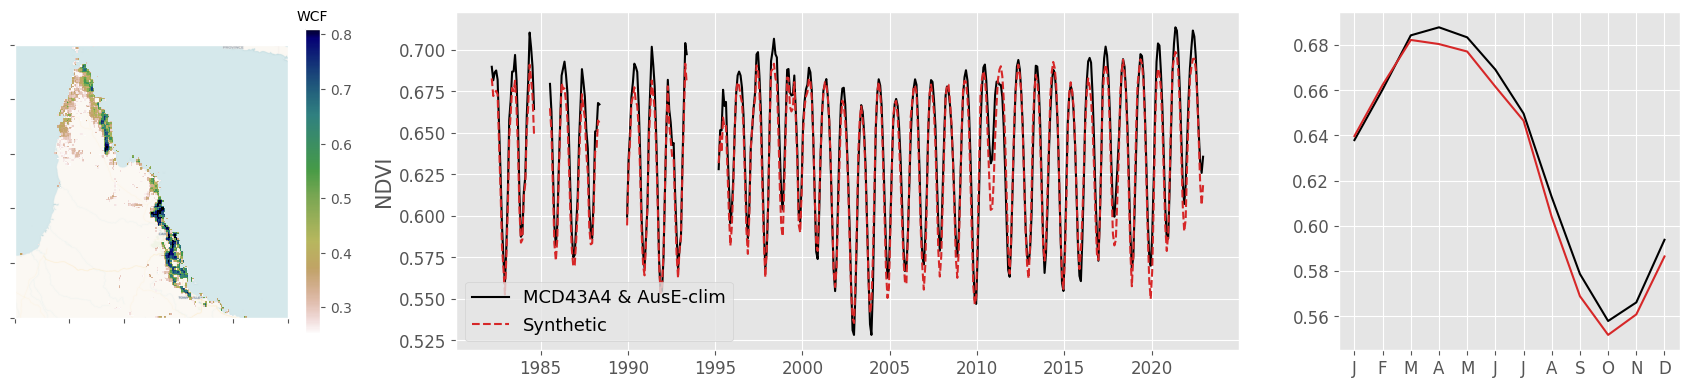

In [13]:
with plt.style.context('ggplot'):

    mosiac = [
        ["A", "B", "B", "C"],
    ]
    
    fig, ax = plt.subplot_mosaic(mosiac, figsize=(17,4))
    
    im = trees.where(trees>0.25).sel(longitude=lon, latitude=lat).plot(robust=True, cmap='gist_earth_r',ax=ax['A'], add_colorbar=False, add_labels=False) 
    cbar = plt.colorbar(im, ax=ax['A'], shrink=0.9)
    cbar.ax.set_title('WCF', fontsize=10)
    ax['A'].set_yticklabels([])
    ax['A'].set_xticklabels([])
    ax['A'].set_ylabel('')
    ax['A'].set_xlabel('')
    ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    
    obs_trees.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='MCD43A4 & AusE-clim', color='black')
    yy_trees.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='Synthetic', color='tab:red',  linestyle='--')
    
    
    ax["B"].grid(True)
    ax["B"].legend(fontsize=13, loc='best')
    ax["B"].set_title(None)
    ax["B"].set_ylabel('NDVI', fontsize=15)
    ax["B"].set_xlabel(None)
    # ax["B"].set_ylim(0.425, 0.775)
    ax['B'].tick_params(axis='y', labelsize=12)
    ax['B'].tick_params(axis='x', labelsize=12)
    
    obs_trees.sel(longitude=lon, latitude=lat).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='MCD43A4 & AusE-clim', color='black')
    yy_trees.sel(longitude=lon, latitude=lat).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='Synthetic', color='tab:red')
    
    # ax["C"].legend(fontsize=10)
    ax["C"].set_title(None)
    ax["C"].set_ylabel(None)
    ax["C"].set_xlabel(None)
    # ax["C"].set_ylim(0.425, 0.775)
    ax['C'].tick_params(axis='y', labelsize=12)
    ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])
    ax["C"].set_xticks(range(1,13))
    ax["C"].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"],fontsize=12);
    
    plt.tight_layout();
fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/"+plotname+"_trees_timeseries.png",
            bbox_inches='tight', dpi=300);

### Plot all WCF > 0.25

/jobfs/116230023.gadi-pbs/ipykernel_2505983/1784241497.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])


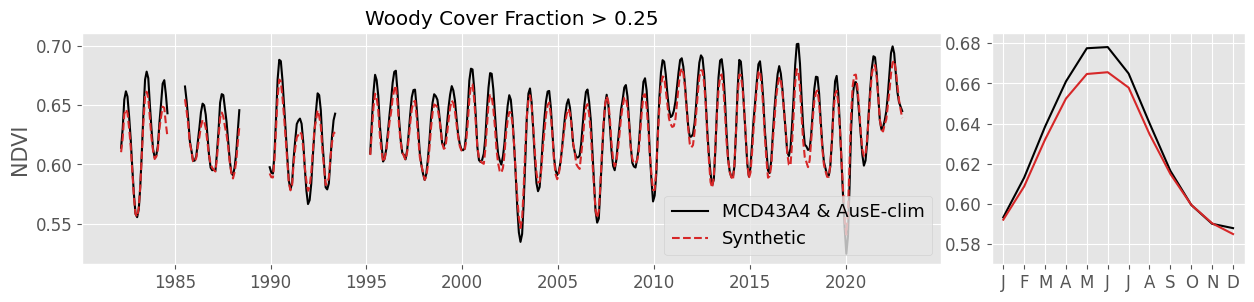

In [14]:
with plt.style.context('ggplot'):

    mosiac = [
        ["B", "B", "B", "C"],
    ]
    
    fig, ax = plt.subplot_mosaic(mosiac, figsize=(15,3))
    
    obs_trees.mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='MCD43A4 & AusE-clim', color='black')
    yy_trees.mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='Synthetic', color='tab:red',  linestyle='--')
    
    
    ax["B"].grid(True)
    ax["B"].legend(fontsize=13, loc='best')
    ax["B"].set_title(None)
    ax["B"].set_ylabel('NDVI', fontsize=15)
    ax["B"].set_xlabel(None)
    # ax["B"].set_ylim(0.425, 0.775)
    ax['B'].tick_params(axis='y', labelsize=12)
    ax['B'].tick_params(axis='x', labelsize=12)
    ax["B"].set_title('Woody Cover Fraction > 0.25')
    
    obs_trees.groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='MCD43A4 & AusE-clim', color='black')
    yy_trees.groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='Synthetic', color='tab:red')
    
    # ax["C"].legend(fontsize=10)
    ax["C"].set_title(None)
    ax["C"].set_ylabel(None)
    ax["C"].set_xlabel(None)
    ax["C"].set_ylim(0.57, 0.685)
    ax['C'].tick_params(axis='y', labelsize=12)
    ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])
    ax["C"].set_xticks(range(1,13))
    ax["C"].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"],fontsize=12);

fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/synthetic_trees_timeseries.png",
            bbox_inches='tight', dpi=300);

### Plot all WCF <= 0.25

/jobfs/116230023.gadi-pbs/ipykernel_2505983/1189598921.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])


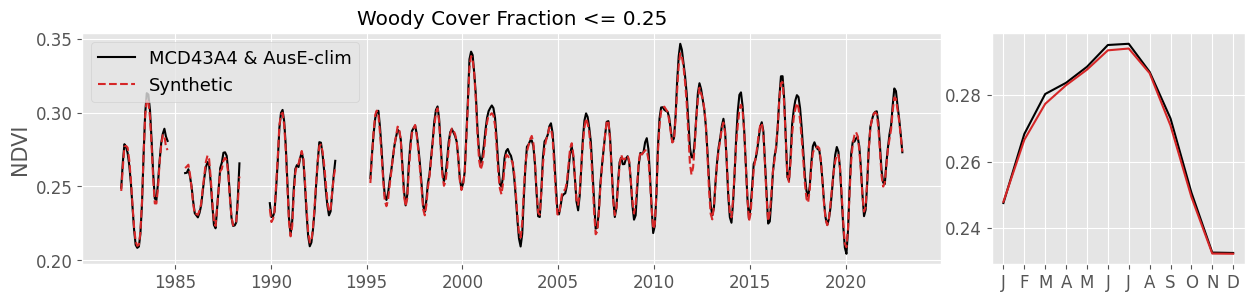

In [15]:
with plt.style.context('ggplot'):

    mosiac = [
        ["B", "B", "B", "C"],
    ]
    
    fig, ax = plt.subplot_mosaic(mosiac, figsize=(15,3))
    
    obs_nontrees.mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='MCD43A4 & AusE-clim', color='black')
    yy_nontrees.mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='Synthetic', color='tab:red',  linestyle='--')
    
    
    ax["B"].grid(True)
    ax["B"].legend(fontsize=13, loc='best')
    ax["B"].set_title(None)
    ax["B"].set_ylabel('NDVI', fontsize=15)
    ax["B"].set_xlabel(None)
    # ax["B"].set_ylim(0.425, 0.775)
    ax['B'].tick_params(axis='y', labelsize=12)
    ax['B'].tick_params(axis='x', labelsize=12)
    ax["B"].set_title('Woody Cover Fraction <= 0.25')
    
    obs_nontrees.groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='MCD43A4 & AusE-clim', color='black')
    yy_nontrees.groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='Synthetic', color='tab:red')
    
    # ax["C"].legend(fontsize=10)
    ax["C"].set_title(None)
    ax["C"].set_ylabel(None)
    ax["C"].set_xlabel(None)
    # ax["C"].set_ylim(0.57, 0.685)
    ax['C'].tick_params(axis='y', labelsize=12)
    ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])
    ax["C"].set_xticks(range(1,13))
    ax["C"].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"],fontsize=12);

fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/synthetic_nontrees_timeseries.png",
            bbox_inches='tight', dpi=300);